In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
import cv2
import random
import pandas as pd
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import os
import ntpath

Using TensorFlow backend.


In [2]:
datadir = 'car-data'
columns = ['center', 'left', 'right', 'steering', 
           'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\darkr\Desktop\car-data\IMG\center_2020_04_18_10_38_50_679.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_679.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_679.jpg,0.0,0.0,0,0.000078
1,C:\Users\darkr\Desktop\car-data\IMG\center_2020_04_18_10_38_50_780.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_780.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_780.jpg,0.0,0.0,0,0.000080
2,C:\Users\darkr\Desktop\car-data\IMG\center_2020_04_18_10_38_50_880.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_880.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_880.jpg,0.0,0.0,0,0.000080
3,C:\Users\darkr\Desktop\car-data\IMG\center_2020_04_18_10_38_50_985.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_985.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_985.jpg,0.0,0.0,0,0.000078
4,C:\Users\darkr\Desktop\car-data\IMG\center_2020_04_18_10_38_51_088.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_51_088.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_51_088.jpg,0.0,0.0,0,0.000079


In [3]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['center'] = data['left'].apply(path_leaf)
data['center'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,right_2020_04_18_10_38_50_679.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_679.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_679.jpg,0.0,0.0,0,0.000078
1,right_2020_04_18_10_38_50_780.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_780.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_780.jpg,0.0,0.0,0,0.000080
2,right_2020_04_18_10_38_50_880.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_880.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_880.jpg,0.0,0.0,0,0.000080
3,right_2020_04_18_10_38_50_985.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_50_985.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_50_985.jpg,0.0,0.0,0,0.000078
4,right_2020_04_18_10_38_51_088.jpg,C:\Users\darkr\Desktop\car-data\IMG\left_2020_04_18_10_38_51_088.jpg,C:\Users\darkr\Desktop\car-data\IMG\right_2020_04_18_10_38_51_088.jpg,0.0,0.0,0,0.000079


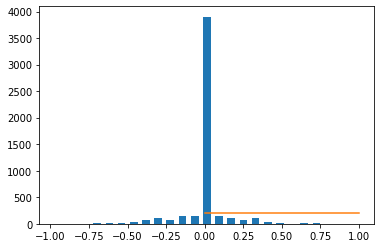

In [4]:
num_bins = 25
samples_per_bin = 200
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']), 
         (samples_per_bin, samples_per_bin))

Total data: 5056
removed 3702
remaining: 1354


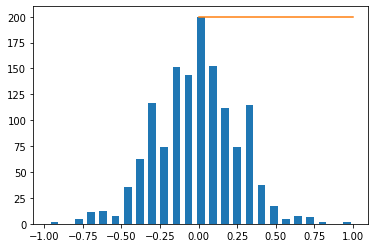

In [5]:
print('Total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot(np.min(data['steering']), np.max(data['steering']), 
         (samples_per_bin, samples_per_bin))

In [6]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_path = np.asarray(image_path)
    steering = np.asarray(steering)
    return image_path, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, 
                                                      test_size=0.2, 
                                                      random_state=0)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 1083
Valid Samples: 271


Text(0.5, 1.0, 'Validation set')

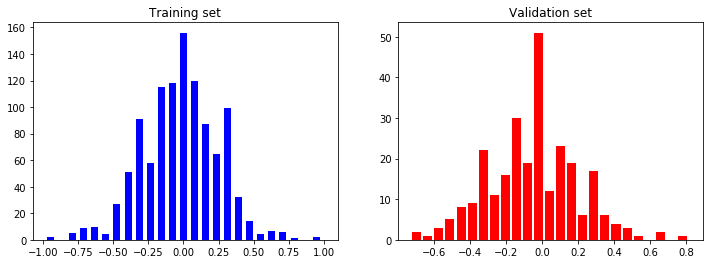

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')


In [9]:
def img_preprocess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img